In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from scripts.network import network
from scripts.training import trainNetwork
from scripts.dynamics import *
from scripts.utils import fineIntegratorParallel
import multiprocessing
import time as tid

In [2]:
system="Robert"
dtype = torch.float64

In [3]:
if system=="SIR":
    d = 3 #number of the ODEs solved by the network
    t_min = 0.
    t_max = 1e4
    y0 = np.array([0.3,0.5,0.2])
else:
    d = 3 #number of the ODEs solved by the network
    t_min = 0. #initial time
    t_max = 1e6 #final time
    y0 = np.array([1.,0.,0])

In [4]:
output = solve_ivp(ode,[t_min,t_max], y0, method = 'BDF', atol=1e-4, rtol=1e-4, args=(system,))

In [5]:
dt = 1
coarse_time = np.linspace(t_min,t_max,1000)
dts = np.diff(coarse_time)

$$
\mathcal{D} = \{(t_j,\Phi^{t_j}(x_i))\}_{i=1,...,N}^{j=1,...,M},\,\,\{x_1,...,x_N\}\subset\Omega\subset\mathbb{R}^3,\,\,t_j\in [0,\Delta t]
$$

In [6]:
fact = 1e4 * (system=="Robert") + 1. * (system=="SIR")

$$
\dot{x}(t) = f(x(t)),\,\,t\in [0,T]
$$
$$
\dot{y}(t) = \dot{\tau}(t)f(y(s)),\,\,t\in [0,1]
$$
$$
s = \tau(t)
$$

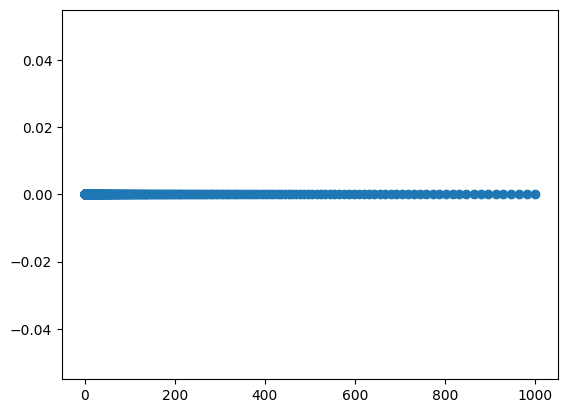

In [7]:
plt.plot(np.logspace(-5,3,1000),np.zeros(1000),'o')

In [9]:
net = network(d=d,nlayers=3,system=system,num_hidden=30,dtype=dtype)

lr = 1e-3
wd = 0.
epochs = int(4e5)

path = "trained_model.pt"
is_training = False#input("Do you want to train the model? Write ""y"" to do it")=="y"

if is_training:
    loss = trainNetwork(dt,net,net.d,lr,wd,epochs,system,dtype=dtype)
    torch.save(net.state_dict(), path)
else:
    net.load_state_dict(torch.load(path))

RuntimeError: Error(s) in loading state_dict for network:
	Missing key(s) in state_dict: "linears.0.weight", "linears.0.bias", "linears.1.weight", "linears.1.bias", "linears.2.weight", "linears.2.bias". 
	size mismatch for lift.weight: copying a param with shape torch.Size([10, 4]) from checkpoint, the shape in current model is torch.Size([30, 4]).
	size mismatch for lift.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([30]).
	size mismatch for proj.weight: copying a param with shape torch.Size([3, 10]) from checkpoint, the shape in current model is torch.Size([3, 30]).

In [ ]:
t_max = 5000

In [ ]:
initial = tid.time()
t_eval = np.linspace(t_min,t_max,1000)
output = solve_ivp(ode,[t_min,t_max], y0=y0, t_eval=t_eval, method = 'BDF', atol=1e-10, rtol=1e-10, args=(system,))
sol,time = output.y,output.t
final = tid.time()
print("Required time: ",final-initial)

Required time:  0.23630118370056152


In [ ]:
coarse_time = np.linspace(t_min,t_max,1000) #time[which_idxs(N+1,M)]

In [ ]:
net.eval();

In [ ]:
t_int = np.arange(0,t_max)
predictions_integer_times = torch.zeros((len(t_int),d)) #sequential step
predictions_integer_times[0] = torch.from_numpy(y0.astype(np.float32))
dtt = torch.tensor([[dt]],dtype=dtype)
for i in range(len(predictions_integer_times)-1):
    predictions_integer_times[i+1:i+2] = net(dtt,predictions_integer_times[i:i+1])
n_t = 10
times_0_1 = torch.linspace(0,1,n_t).unsqueeze(1).repeat(len(t_int),1)
p = torch.ones(n_t,1,dtype=dtype)
ics = torch.kron(predictions_integer_times,p)
result = net(times_0_1,ics).detach().cpu().numpy().T


In [ ]:
t = torch.linspace(0,t_max,6000,dtype=dtype).unsqueeze(1)
yy0 = torch.from_numpy(y0)

def approx(y0,tt):
    count = 1
    sol = torch.zeros((len(tt),3),dtype=dtype)
    sol[0] = y0
    pos = 0
    for i in range(1,len(tt)):
        t = tt[i:i+1]
        if t>count*dt:
            count+=1
            pos = i-1
        sol[i:i+1] = net(t-dt*(count-1),sol[pos:pos+1])
    return (sol.T).detach().cpu().numpy()

pred = approx(yy0,t)

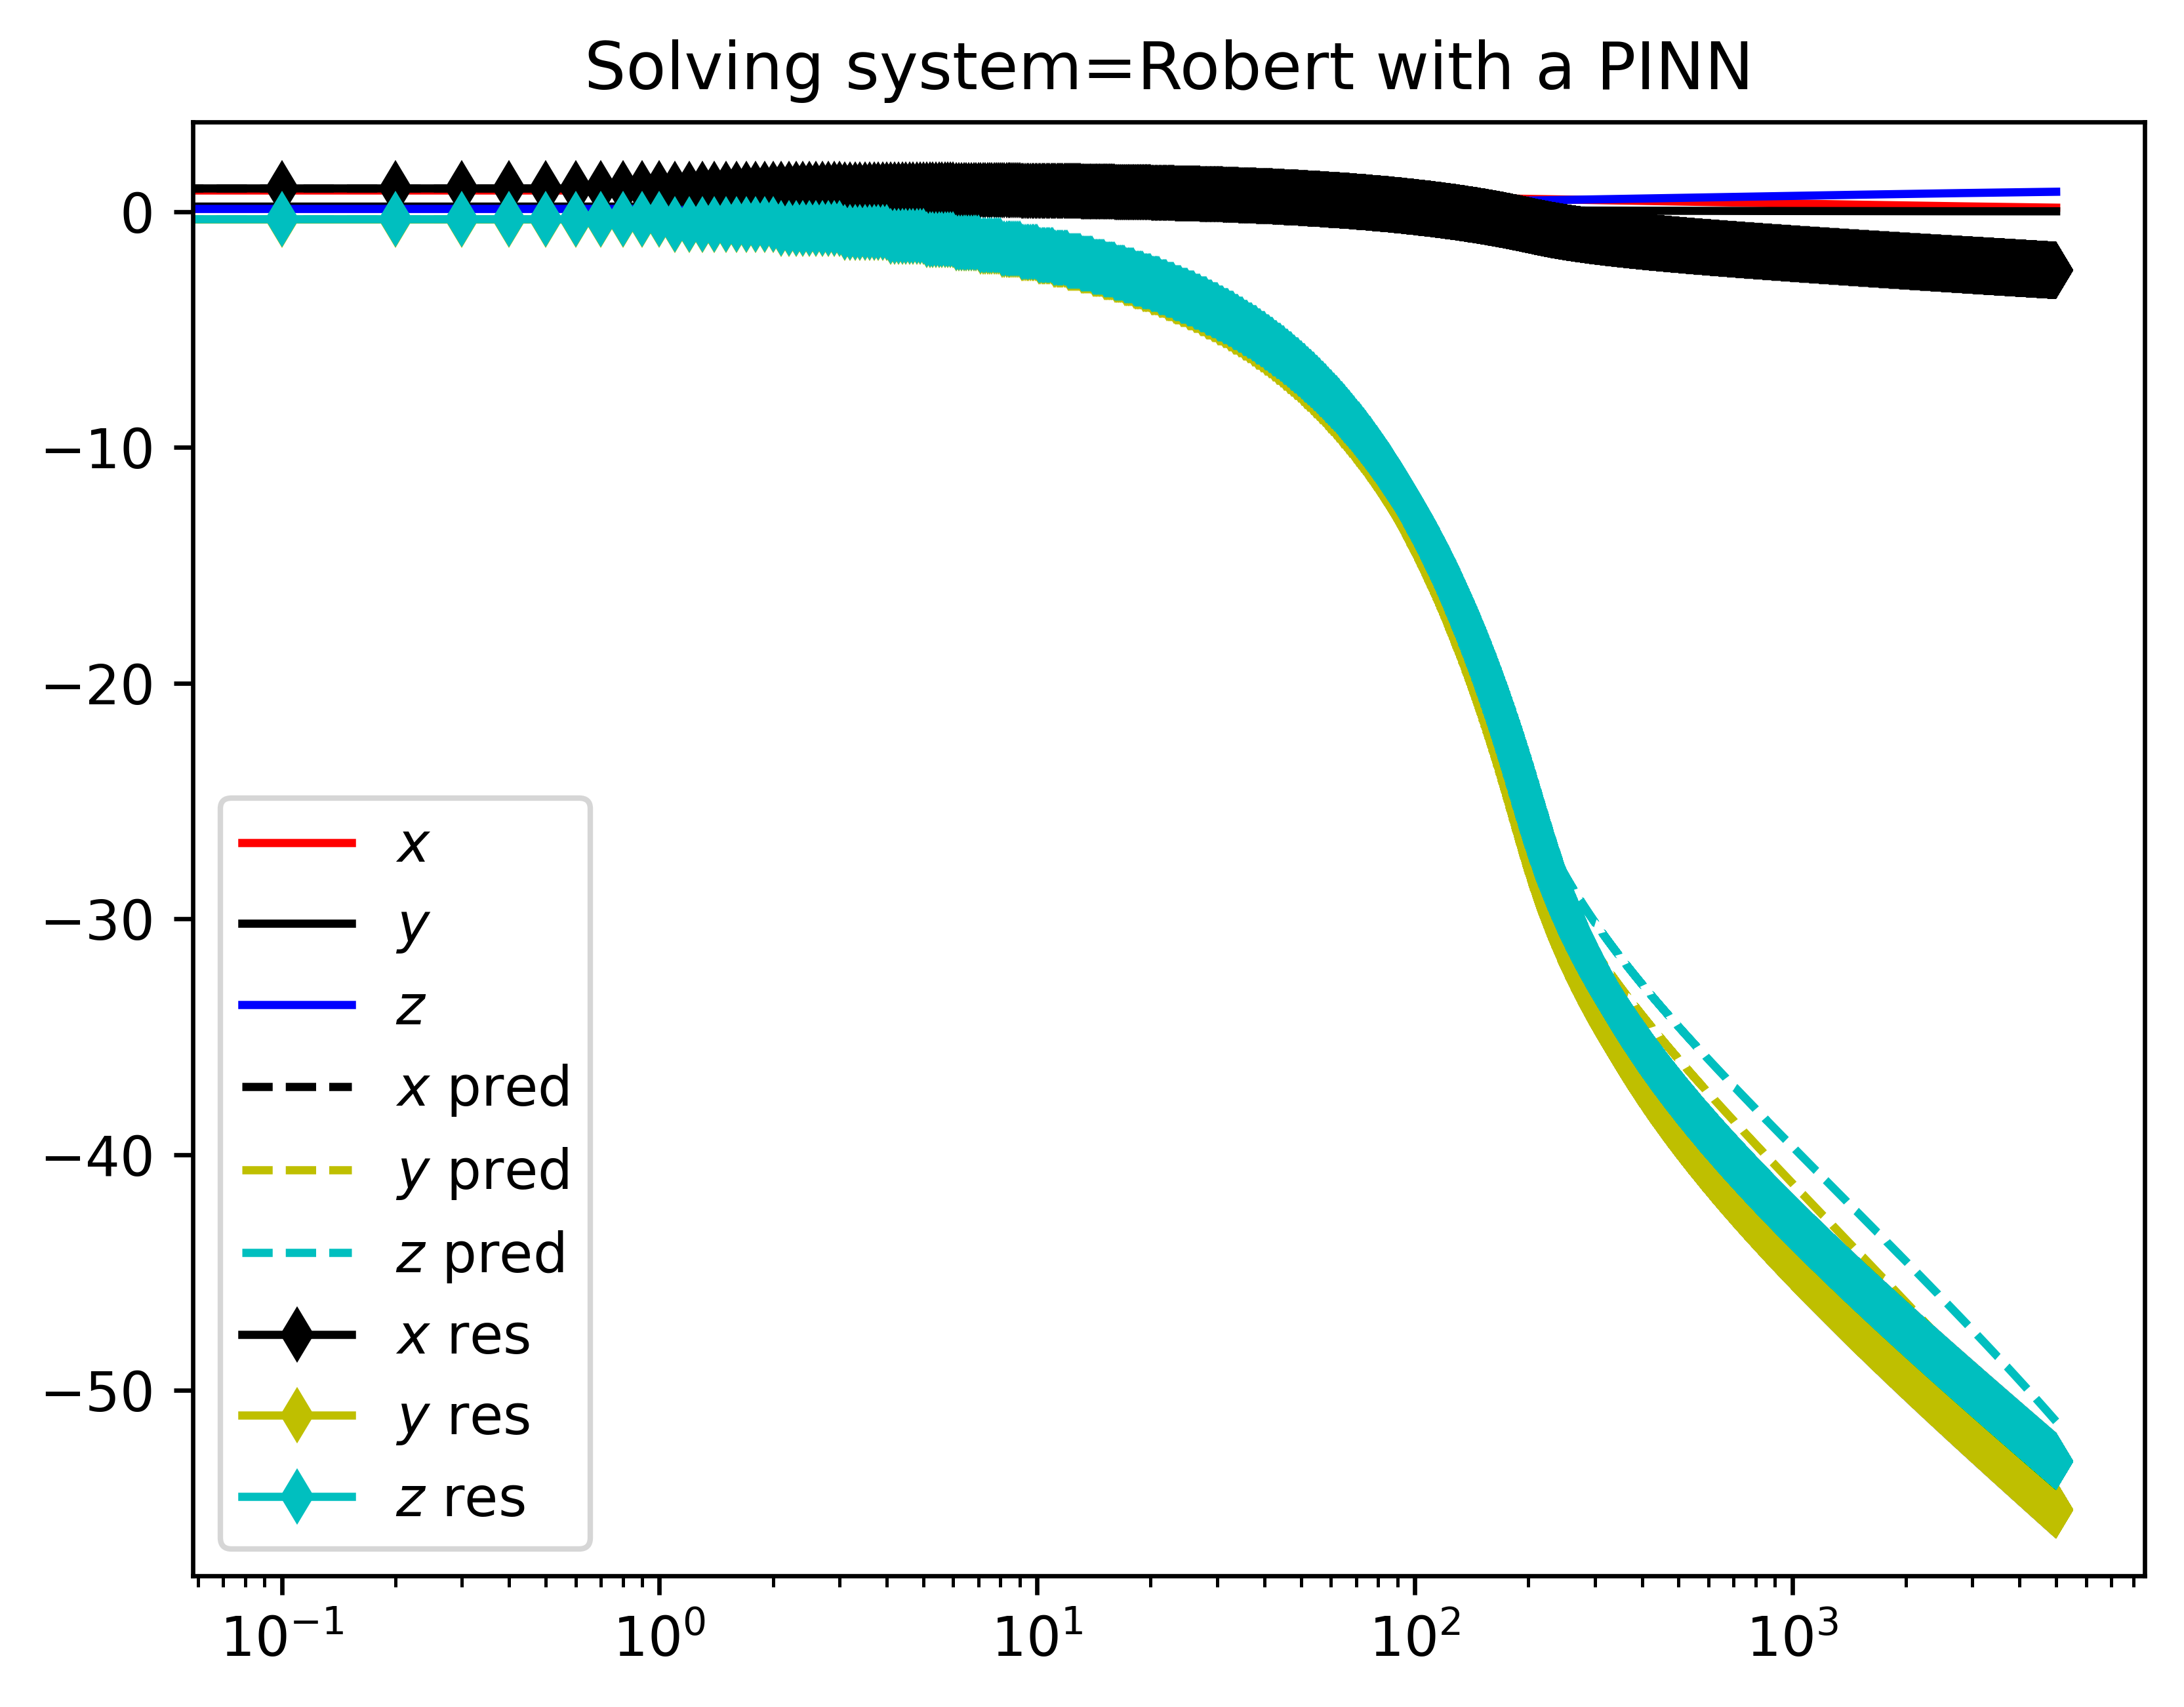

In [ ]:
fig = plt.figure(dpi=600)

plt.semilogx(time,sol[0],'r-',label=r'$x$')
plt.semilogx(time,sol[1]*fact,'k-',label=r'$y$')
plt.semilogx(time,sol[2],'b-',label=r'$z$')

plt.semilogx(t,pred[0],'k--',label=r'$x$ pred')
plt.semilogx(t,pred[1]*fact,'y--',label=r'$y$ pred')
plt.semilogx(t,pred[2],'c--',label=r'$z$ pred')

plt.semilogx(t,result[0],'k-d',label=r'$x$ res')
plt.semilogx(t,result[1]*fact,'y-d',label=r'$y$ res')
plt.semilogx(t,result[2],'c-d',label=r'$z$ res')

#plt.plot(np.ones(50)*10.,np.linspace(0,1,50),'k-')
    
plt.legend()
plt.title(f"Solving system={system} with a PINN")
plt.savefig(f"system={system}.pdf")
plt.show();

$$
L = \frac{1}{1000}\sum_{i=1}^{1000} \left\|\frac{d}{dt}\mathcal{N}_{\theta}(t^i,x_0^i) - X(\mathcal{N}_{\theta}(t^i,x_0^i))\right\|_2^2
$$
$$
t_i \sim \mathcal{U}([0,\Delta t]),\,\,x_0^i\sim \mathcal{U}([0,1]^3)
$$

In [ ]:
def getCoarse(previous=[]):
    coarse_approx = np.zeros((len(time),3))
    dt_torch = torch.tensor([[dt]],dtype=dtype)
    coarse_approx[0] = y0
    
    if len(previous)==0:
        for i in range(len(time)-1):
            coarse_approx[i+1:i+2] = net(dt_torch,torch.from_numpy(coarse_approx[i:i+1])).detach().cpu().numpy()
        return coarse_approx

    else:
        #We can make this faster by processing all the times as a batch, and then reshape it
        
        tt = torch.ones((len(time)-1,1),dtype=dtype)
        coarse_approx = net(tt,torch.from_numpy(previous)).detach().cpu().numpy()
        
        '''for i in range(len(time)-1):
            coarse_approx[i+1:i+2] = net(dt_torch,torch.from_numpy(previous[i:i+1])).detach().cpu().numpy()'''
        return coarse_approx
    
def getNextCoarse(y):
    dt_torch = torch.tensor([[dt]],dtype=dtype)
    y_torch = torch.from_numpy(y).reshape(1,-1)
    return net(dt_torch,y_torch)[0].detach().cpu().numpy()


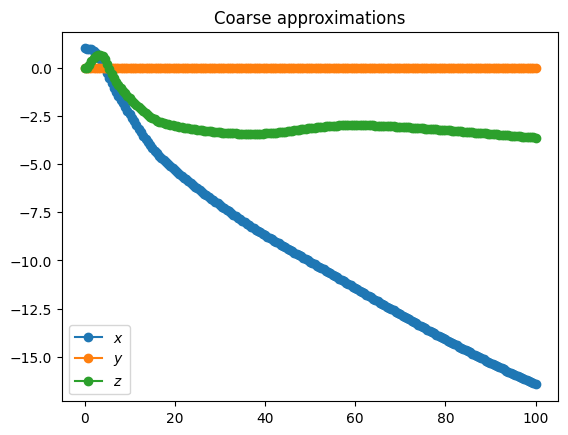

In [ ]:
time = np.linspace(0,100,201)
dt = time[1]-time[0]


##First level of coarse approximation
coarse_approx = getCoarse()

plt.plot(time,coarse_approx[:,0],'-o',label=r"$x$")
plt.plot(time,coarse_approx[:,1],'-o',label=r"$y$")
plt.plot(time,coarse_approx[:,2],'-o',label=r"$z$")
plt.legend()
plt.title("Coarse approximations")
plt.show();

In [ ]:
max_processors = multiprocessing.cpu_count()

In [ ]:
max_it = 10 #maximum number of parareal iterates
tol = 1e-4
computational_times_per_iterate = []
it = 0
is_converged = False
while it<max_it and is_converged==False:
    
    norm_difference = []
    
    if it==0:
        initial_time = tid.time()
        coarse_approx = getCoarse()
        coarse_values_parareal = coarse_approx
        computational_times_per_iterate.append(tid.time()-initial_time)
    else:
        initial_time = tid.time()
        coarse_approx = getCoarse(coarse_values_parareal)
        
        start_fine = tid.time()
        with multiprocessing.Pool(max_processors) as pool:
            fine_int = pool.starmap(fineIntegratorParallel, [(coarse_values_parareal,i,system,dt,ode) for i in range(len(time)-1)])
        print("Time required for the fine solver : ",tid.time()-start_fine)
        for i in range(len(time)-1):     
            #This is the value at index i+1
            #supp = solve_ivp(ode,[0,dt], y0=coarse_values_parareal[i], method = 'Radau', atol=1e-6, rtol=1e-6, args=(system,)).y.T #Sequential
            previous = coarse_values_parareal[i+1].copy()
            coarse_values_parareal[i+1] = fine_int[i] + getNextCoarse(coarse_values_parareal[i]) - coarse_approx[i+1]
            
            norm_difference = np.linalg.norm(coarse_values_parareal[i+1]-previous,2)
            
        computational_times_per_iterate.append(tid.time()-initial_time)
        print("Maximum norm of difference :",np.round(np.max(norm_difference),10))
        is_converged = np.max(norm_difference)<tol
        
    it+=1
    print(f"Iterate {it} completed")
    print(f"Time for iterate {it} is {computational_times_per_iterate[-1]}")    

Iterate 1 completed
Time for iterate 1 is 0.08951616287231445


RuntimeError: The size of tensor a (201) must match the size of tensor b (200) at non-singleton dimension 0

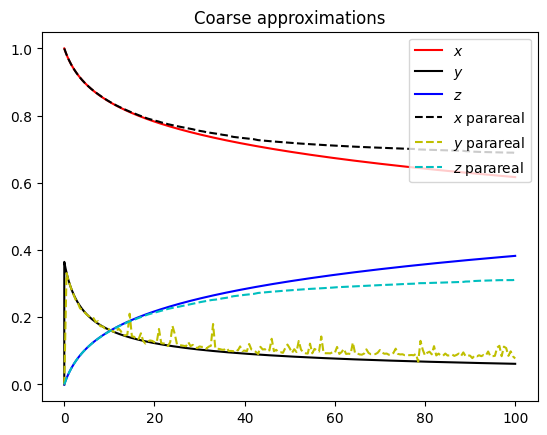

In [ ]:
plt.plot(output.t,output.y[0],'r-',label=r"$x$")
plt.plot(output.t,output.y[1]*fact,'k-',label=r"$y$")
plt.plot(output.t,output.y[2],'b-',label=r"$z$")

plt.plot(time,coarse_values_parareal[:,0],'k--',label=r"$x$ parareal")
plt.plot(time,coarse_values_parareal[:,1]*fact,'y--',label=r"$y$ parareal")
plt.plot(time,coarse_values_parareal[:,2],'c--',label=r"$z$ parareal")
plt.legend()
plt.title("Coarse approximations")
plt.show();